In [1]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")
print("--- Phase 3: Exploratory Data Analysis (EDA) ---")

--- Phase 3: Exploratory Data Analysis (EDA) ---


In [2]:
# Cell 2: Connect to the Database
# Define the path and table name
db_path = '/workspaces/Engine_Predictive_System/data/turbofan.db'
table_name = 'train_data_FD001'

# Connect
try:
    conn = sqlite3.connect(db_path)
    print(f"Successfully connected to {db_path}")
except Exception as e:
    print(f"Error connecting to DB: {e}")

Successfully connected to /workspaces/Engine_Predictive_System/data/turbofan.db


In [3]:
#SQL Query 1 - Engine Runtimes
print("--- SQL: What are the 10 longest-lasting engines? ---")
query_1 = f"""
    SELECT unit_number, MAX(time_cycle) as total_cycles
    FROM {table_name}
    GROUP BY unit_number
    ORDER BY total_cycles DESC
    LIMIT 10;
"""
df_longest_life = pd.read_sql_query(query_1, conn)
print(df_longest_life)

print("\n--- SQL: What are the 10 shortest-lasting engines? ---")
query_2 = f"""
    SELECT unit_number, MAX(time_cycle) as total_cycles
    FROM {table_name}
    GROUP BY unit_number
    ORDER BY total_cycles ASC
    LIMIT 10;
"""
df_shortest_life = pd.read_sql_query(query_2, conn)
print(df_shortest_life)

--- SQL: What are the 10 longest-lasting engines? ---
   unit_number  total_cycles
0           69           362
1           92           341
2           96           336
3           67           313
4           83           293
5            2           287
6           95           283
7           64           283
8           86           278
9           17           276

--- SQL: What are the 10 shortest-lasting engines? ---
   unit_number  total_cycles
0           39           128
1           91           135
2           57           137
3           70           137
4           24           147
5           58           147
6            8           150
7           65           153
8           77           154
9           90           154


In [4]:
# SQL Query 2 - Sensor Averages Near Failure
# This is a key analytical query.
# How do sensor values behave in the last 20 cycles vs. early in life?

print("\n--- SQL: Average sensor values in last 20 cycles vs. first 20 cycles ---")
query_3 = f"""
    SELECT 
        'Last 20 Cycles' as period,
        AVG(sensor_2) as avg_s2,
        AVG(sensor_3) as avg_s3,
        AVG(sensor_4) as avg_s4,
        AVG(sensor_7) as avg_s7,
        AVG(sensor_11) as avg_s11,
        AVG(sensor_12) as avg_s12,
        AVG(sensor_15) as avg_s15
    FROM {table_name}
    WHERE RUL <= 20
    
    UNION ALL
    
    SELECT 
        'First 20 Cycles' as period,
        AVG(sensor_2) as avg_s2,
        AVG(sensor_3) as avg_s3,
        AVG(sensor_4) as avg_s4,
        AVG(sensor_7) as avg_s7,
        AVG(sensor_11) as avg_s11,
        AVG(sensor_12) as avg_s12,
        AVG(sensor_15) as avg_s15
    FROM {table_name}
    WHERE time_cycle <= 20;
"""
df_sensor_comparison = pd.read_sql_query(query_3, conn)
print(df_sensor_comparison.T) # .T transposes for easier reading


--- SQL: Average sensor values in last 20 cycles vs. first 20 cycles ---
                      0                1
period   Last 20 Cycles  First 20 Cycles
avg_s2       643.472662       642.380765
avg_s3      1599.924586       1586.83983
avg_s4      1424.739071      1402.758335
avg_s7       551.860814       553.950605
avg_s11       48.023795        47.352475
avg_s12      520.129395        521.90987
avg_s15        8.505556         8.418291


In [5]:
#Load Full Dataset into Pandas
print("\n--- Loading full dataset into Pandas for visualization ---")
query_all = f"SELECT * FROM {table_name};"
df_full = pd.read_sql_query(query_all, conn)

# Close the connection, we have all the data in memory now.
conn.close()

print(f"Data loaded: {df_full.shape[0]} rows, {df_full.shape[1]} columns")


--- Loading full dataset into Pandas for visualization ---
Data loaded: 20631 rows, 18 columns



Plotting degradation for sensors: sensor_2, sensor_3, sensor_4, sensor_6...


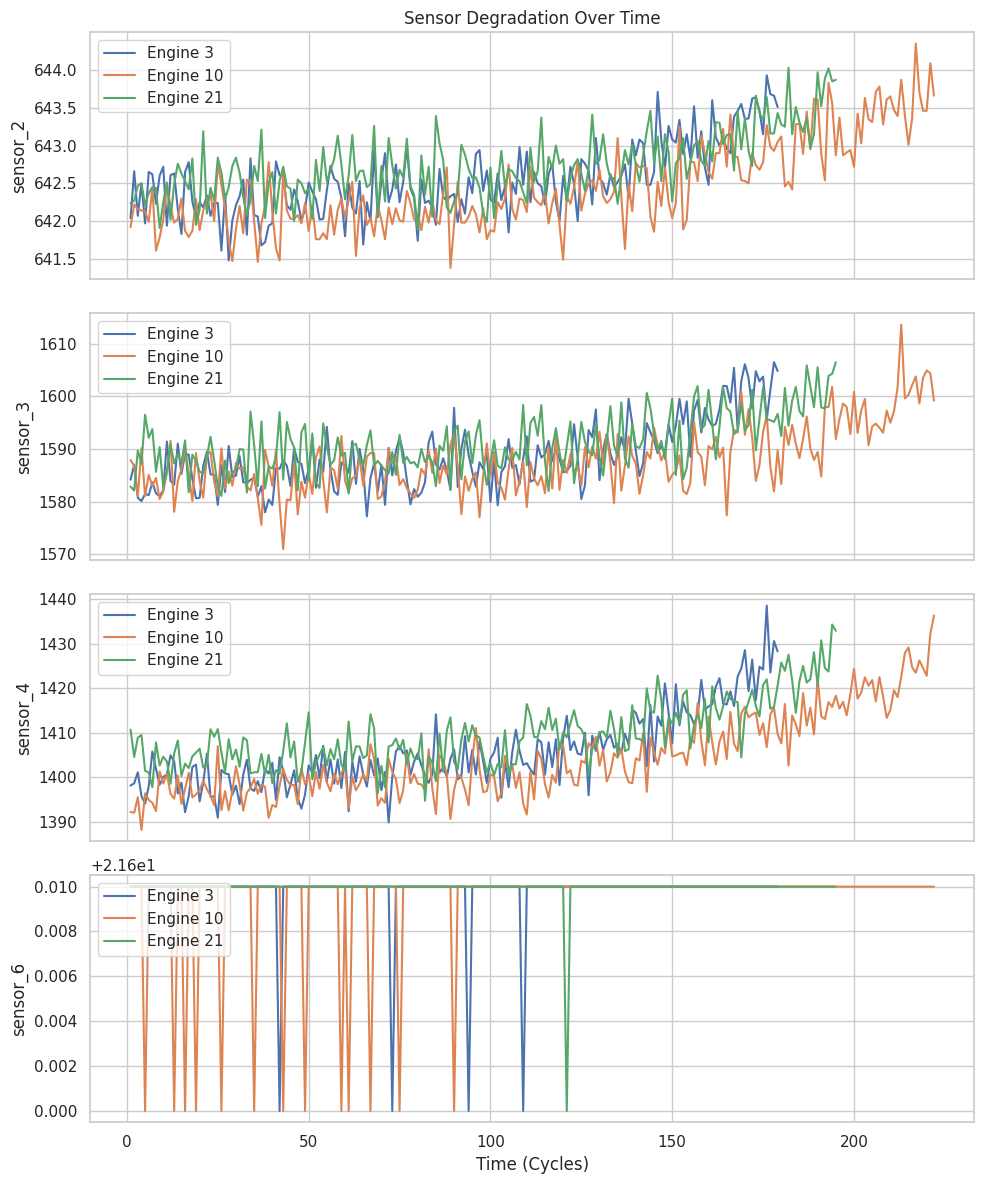

In [6]:
# Visualize Sensor Degradation
# Let's plot the sensor values over time for a few sample engines
# This is the *key* visualization to show degradation.

# Get the list of sensor columns
sensor_cols = [col for col in df_full.columns if 'sensor_' in col]
sample_engines = [3, 10, 21] # Pick a few from our SQL queries

print(f"\nPlotting degradation for sensors: {', '.join(sensor_cols[0:4])}...")

# Create a plot
fig, axes = plt.subplots(nrows=len(sensor_cols[0:4]), ncols=1, figsize=(10, 12), sharex=True)

for i, sensor in enumerate(sensor_cols[0:4]): # Plot the first 4 sensors
    ax = axes[i]
    for engine_id in sample_engines:
        # Get data for one engine
        engine_data = df_full[df_full['unit_number'] == engine_id]
        ax.plot(engine_data['time_cycle'], engine_data[sensor], label=f'Engine {engine_id}')
    
    ax.set_ylabel(sensor)
    ax.legend(loc='upper left')
    if i == 0:
        ax.set_title('Sensor Degradation Over Time')
    if i == len(sensor_cols[0:4]) - 1:
        ax.set_xlabel('Time (Cycles)')

plt.tight_layout()
plt.show()

# You will notice:
# - Some sensors (like sensor_4, sensor_7) trend clearly up or down.
# - Some sensors (like sensor_2) are very noisy but might have a trend.
# - Some sensors are just noise.
# This visually confirms which sensors are useful!


--- Calculating Correlation Heatmap ---
--- Correlation with RUL ---
RUL            1.000000
sensor_12      0.671983
sensor_7       0.657223
sensor_21      0.635662
sensor_20      0.629428
unit_number    0.078753
sensor_6      -0.128348
sensor_14     -0.306769
sensor_9      -0.390102
sensor_13     -0.562569
sensor_8      -0.563968
sensor_3      -0.584520
sensor_17     -0.606154
sensor_2      -0.606484
sensor_15     -0.642667
sensor_4      -0.678948
sensor_11     -0.696228
time_cycle    -0.736241
Name: RUL, dtype: float64


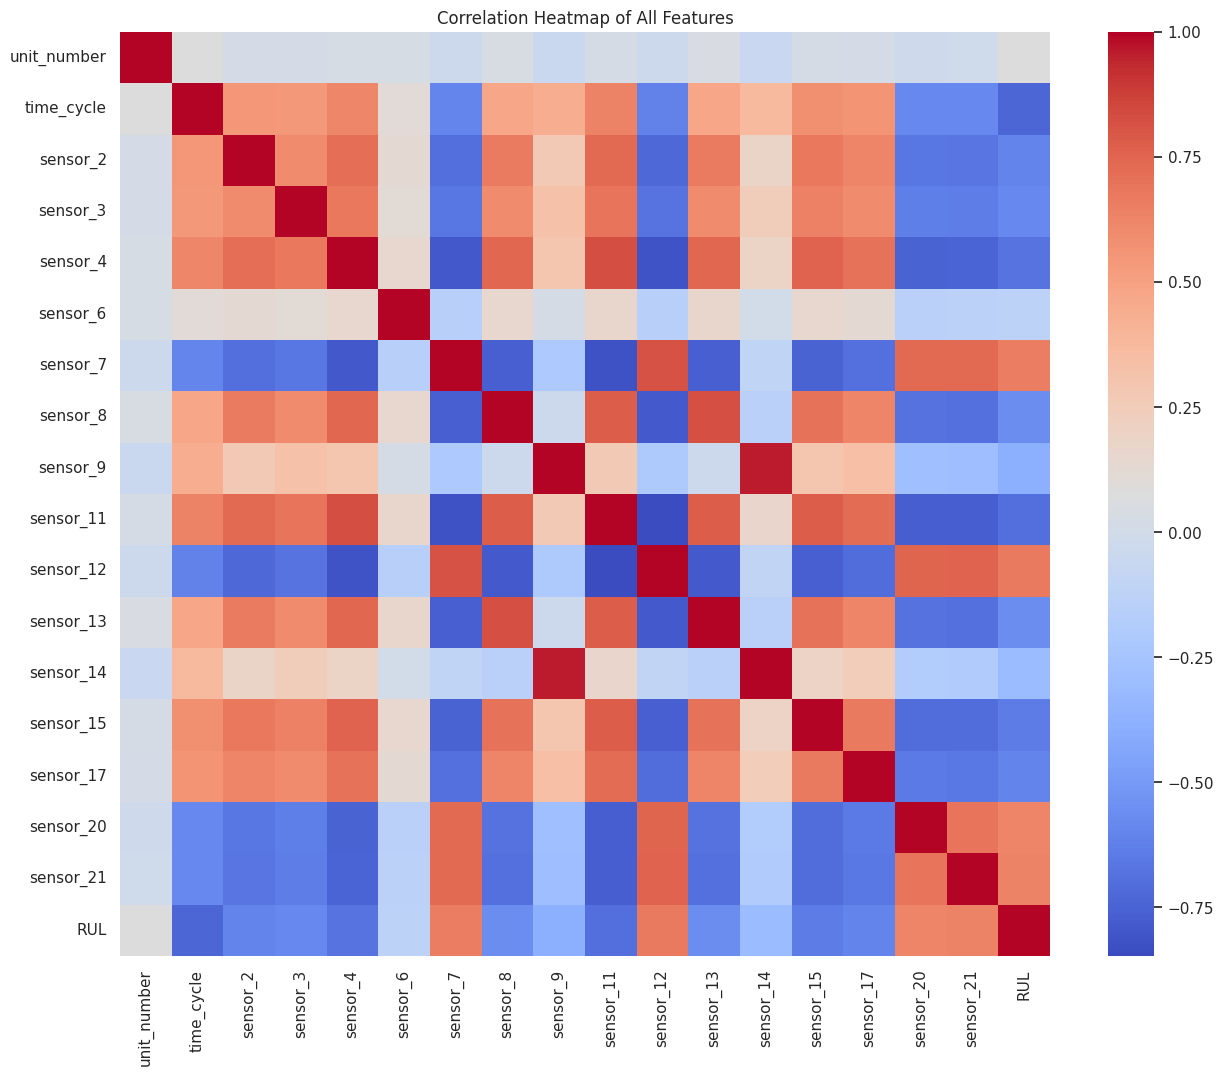

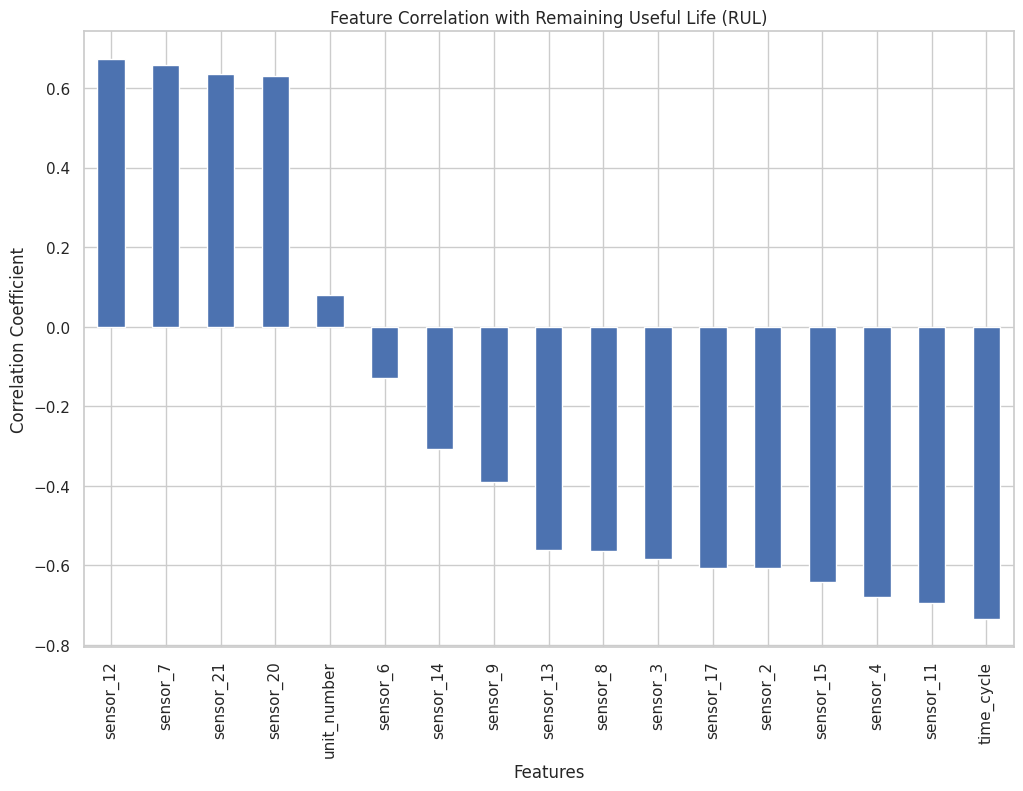

In [7]:
#  *** KEY FINDING: Correlation Heatmap ***
# This is the single most important plot from our EDA.
# We'll check the correlation of all sensors with our target variable: 'RUL'

print("\n--- Calculating Correlation Heatmap ---")

# Calculate the correlation matrix
corr_matrix = df_full.corr(numeric_only=True)

# Focus on the 'RUL' column
rul_correlation = corr_matrix['RUL'].sort_values(ascending=False)

print("--- Correlation with RUL ---")
print(rul_correlation)

# Plot the full heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.1f')
plt.title('Correlation Heatmap of All Features')
plt.show()

# Plot just the RUL correlations as a bar chart
plt.figure(figsize=(12, 8))
rul_correlation.drop('RUL').plot(kind='bar') # Drop 'RUL' itself (correlates 1.0)
plt.title('Feature Correlation with Remaining Useful Life (RUL)')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.show()